In [2]:
import numpy as np
import ast
from scipy.spatial import KDTree
from numpy.linalg import svd
import pyransac3d as pyrsc
from scipy.spatial.transform import Rotation as R
import open3d as o3d

def load_point_cloud(filename):
    with open(filename, 'r') as file:
        # Read lines, stripping the newline characters and leading/trailing brackets
        lines = file.read().strip()[2:-2].split(']\n [')

    # Process each line
    list_of_lists = []
    for line in lines:
        # Split the line by spaces into individual strings, filtering out empty strings
        numbers_str = filter(None, line.split(' '))
        # Convert each string into a float and append to the list_of_lists
        list_of_lists.append([float(num) for num in numbers_str])

    # Convert the list to a NumPy array
    array_np = np.array(list_of_lists)

    return array_np[:,0:3]

def compute_normals(points, k=10):
    # Build a KD-tree for the point cloud
    tree = KDTree(points)

    normals = []

    for point in points:
        # For each point, find its k nearest neighbors
        _, idx = tree.query(point, k=k+1)  # k+1 because the point itself is included

        # Extract the neighbors
        neighbors = points[idx[1:]]  # Skip the first one since it's the point itself

        # Compute the covariance matrix of the neighbors
        cov_matrix = np.cov(neighbors, rowvar=False)

        # Use SVD to find the principal components
        _, _, vh = svd(cov_matrix)

        # The normal vector is the last singular vector (corresponding to the smallest singular value)
        normal = vh[-1, :]

        normals.append(normal)

    return np.array(normals)

# Path to your point cloud file
filename = 'apple_points.txt'

# Load the point cloud
points = np.loadtxt(filename, delimiter=',')

# Compute the surface normals
normals = compute_normals(points, k=10)

# Optionally, you can save the normals to a file or process them further
print("First 5 normals:", normals[:5])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
First 5 normals: [[-0.06954801 -0.85005462  0.52208258]
 [ 0.14064632 -0.83447317  0.53279746]
 [ 0.25127654 -0.90587772  0.34094818]
 [ 0.26846228 -0.89009899  0.36830938]
 [ 0.42693226 -0.82844296  0.36250671]]


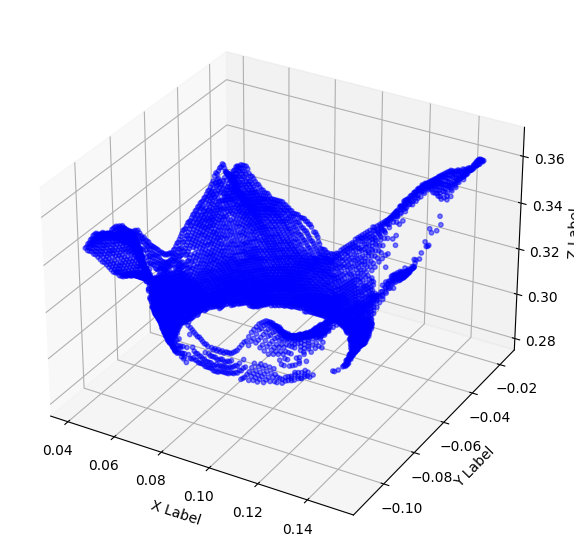

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_cloud_with_normals(points, normals, every_n=50):
    """
    Visualizes the point cloud and the computed normals.

    Parameters:
    - points: The point cloud as an Nx3 numpy array.
    - normals: The computed normals as an Nx3 numpy array.
    - every_n: Only plots every nth normal for clarity. Default is 50.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the point cloud
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.5, s=10)

    # Plot the normals
    # step = every_n  # Only plot every 'every_n' normals for clarity
    # ax.quiver(
    #     points[::step, 0], points[::step, 1], points[::step, 2],
    #     normals[::step, 0], normals[::step, 1], normals[::step, 2],
    #     length=0.01, color='red'
    # )

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

# Assuming 'points' and 'normals' are already loaded or computed from the previous steps
visualize_point_cloud_with_normals(points, normals, every_n=1)

In [4]:
def detect_shape(points, camera_horizontal_orient = True):
    if camera_horizontal_orient != True:
        cubid_1 = pyrsc.Cuboid()
        cubest_eq, cubest_inliers = cubid_1.fit(points, 0.002)
    plane_1 = pyrsc.Plane()
    plbest_eq, plbest_inliers = plane_1.fit(points, 0.002)
    cylinder_1 = pyrsc.Cylinder()
    cycenter, axis, cyradius, cybest_inliers = cylinder_1.fit(points, 0.0001)
    sphere_1 = pyrsc.Sphere()
    sphcenter, sphradius, sphbest_inliers = sphere_1.fit(points, 0.00000)

    if camera_horizontal_orient != True:
        inliers_counts = {
            "Cuboid": len(cubest_inliers),
            "Plane": len(plbest_inliers),
            "Cylinder": len(cybest_inliers),
            "Sphere": len(sphbest_inliers)
        }
    else:
        inliers_counts = {
        "Plane": len(plbest_inliers),
        "Cylinder": len(cybest_inliers),
        "Sphere": len(sphbest_inliers)
        }
    print(inliers_counts)
    # Determine the shape with the most inliers
    best_shape = max(inliers_counts, key=inliers_counts.get)

    # Return the shape and its parameters
    if best_shape == "Cuboid":
        return best_shape, cubest_eq, cubest_inliers
    elif best_shape == "Plane":
        return best_shape, plbest_eq, plbest_inliers
    elif best_shape == "Cylinder":
        return best_shape, (cycenter, axis, cyradius), cybest_inliers
    elif best_shape == "Sphere":
        return best_shape, (sphcenter, sphradius), sphbest_inliers

In [5]:
best_shape, equation, inliers = detect_shape(points)
print(equation)

/home/enis/.local/lib/python3.8/site-packages/pyransac3d/cylinder.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  ma = (P_rot[1, 1] - P_rot[0, 1]) / (P_rot[1, 0] - P_rot[0, 0])
/home/enis/.local/lib/python3.8/site-packages/pyransac3d/cylinder.py:85: RuntimeWarning: invalid value encountered in scalar divide
  p_center_x = (
/home/enis/.local/lib/python3.8/site-packages/pyransac3d/cylinder.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  ma * mb * (P_rot[0, 1] - P_rot[2, 1])
/home/enis/.local/lib/python3.8/site-packages/pyransac3d/cylinder.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  mb = (P_rot[2, 1] - P_rot[1, 1]) / (P_rot[2, 0] - P_rot[1, 0])
/home/enis/.local/lib/python3.8/site-packages/pyransac3d/cylinder.py:86: RuntimeWarning: invalid value encountered in scalar add
  ma * mb * (P_rot[0, 1] - P_rot[2, 1])


{'Plane': 1477, 'Cylinder': 121, 'Sphere': 4}
[-0.4681890992897557, 0.7556439338985221, -0.45804062316416133, 0.18665008693785584]


In [4]:
def plane_normal_to_quaternion(A, B, C):
    # Normalize the plane's normal vector
    normal_vector = np.array([A, B, C])
    normalized_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Z-axis unit vector
    z_axis = np.array([0, 0, 1])
    
    # Calculate rotation axis (cross product) and angle (arc cosine of the dot product)
    rotation_axis = np.cross(z_axis, normalized_vector)
    if np.all(rotation_axis == 0):  # If the normal is parallel to the Z-axis
        return np.array([0, 0, 0, 1])  # No rotation needed
    rotation_angle = np.arccos(np.dot(z_axis, normalized_vector))
    
    # Calculate the quaternion
    rotation = R.from_rotvec(rotation_axis / np.linalg.norm(rotation_axis) * rotation_angle)
    quaternion = rotation.as_quat()  # Returns [x, y, z, w] quaternion
    
    return quaternion

In [7]:
plane_normal_to_quaternion(-1, 1, 0)

array([-0.5       , -0.5       ,  0.        ,  0.70710678])

In [8]:
def transform_points(points, quaternion):
    """Applies rotation defined by a quaternion to a list of points."""
    rotation = R.from_quat(quaternion)
    # Rotate points
    return rotation.apply(points)

def find_extreme_points(transformed_points):
    """Finds the most outward points along the x and y axes and the origin in the transformed space."""
    # Most outward along x-axis
    x_max_point = transformed_points[np.argmax(transformed_points[:, 0])]
    # Most outward along y-axis
    y_max_point = transformed_points[np.argmax(transformed_points[:, 1])]

    return x_max_point, y_max_point

In [9]:
transformed_points = transform_points(points, plane_normal_to_quaternion(0, 0, 1))
x_max_point, y_max_point = find_extreme_points(transformed_points)
#x_max_point, y_max_point = find_extreme_points(points)
print(x_max_point, y_max_point)

[ 0.62025487 -0.54834419  1.05300009] [ 0.61481774 -0.54075652  1.0480001 ]


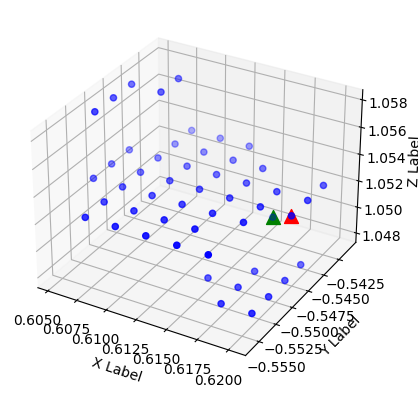

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], c='b', marker='o', label='Points')

# Highlight the most outward points and the origin
ax.scatter(x_max_point[0], x_max_point[1], x_max_point[2], c='r', marker='^', s=100, label='Max X')
ax.scatter(y_max_point[0], y_max_point[1], y_max_point[2], c='g', marker='^', s=100, label='Max Y')

# Labeling
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


plt.show()

In [3]:
point_cloud = o3d.geometry.PointCloud()
#selected_points = points[inliers]
#print(selected_points.shape)
point_cloud.points = o3d.utility.Vector3dVector(points)

aabb = point_cloud.get_axis_aligned_bounding_box()
aabb.color = [1, 0, 0]
print(aabb)

obb = point_cloud.get_oriented_bounding_box(robust=True)
obb.color = [0, 1, 0]

o3d.visualization.draw_geometries([point_cloud, aabb, obb])

AxisAlignedBoundingBox: min: (0.040466, -0.112215, 0.281), max: (0.150316, -0.016352, 0.366)


In [24]:
min_z = np.min(points[:, 2])
max_z = np.max(points[:, 2])
points_xy = points.copy()
points_xy[:, 2] = min_z
point_cloud_same_z = o3d.geometry.PointCloud()
point_cloud_same_z.points = o3d.utility.Vector3dVector(points_xy)

obb_2d = point_cloud_same_z.get_oriented_bounding_box(robust=True)


obb_2d_transformed = o3d.geometry.OrientedBoundingBox(center = np.array([obb_2d.center[0], obb_2d.center[1], (min_z + max_z) / 2]), \
                                                      R =np.array([[obb_2d.R[0,0], obb_2d.R[0,1], 0], [obb_2d.R[1,0], obb_2d.R[1,1], 0],\
                                                                   [0, 0, 1]]), extent = np.array([obb_2d.extent[0], \
                                                                                                   obb_2d.extent[1], max_z - min_z]))
obb_2d_transformed.color = [0, 0, 1]
o3d.visualization.draw_geometries([point_cloud, aabb, obb_2d_transformed])


Qhull messages at ~Qhull()
QH7089 qhull precision warning: The initial hull is narrow.  Is the input lower
dimensional (e.g., a square in 3-d instead of a cube)?  Cosine of the minimum
angle is 1.0000000000000000.  If so, Qhull may produce a wide facet.
Options 'Qs' (search all points), 'Qbb' (scale last coordinate), or
'QbB' (scale to unit box) may remove this warning.
See 'Limitations' in qh-impre.htm.  Use 'Pp' to skip this warning.


KeyboardInterrupt: 

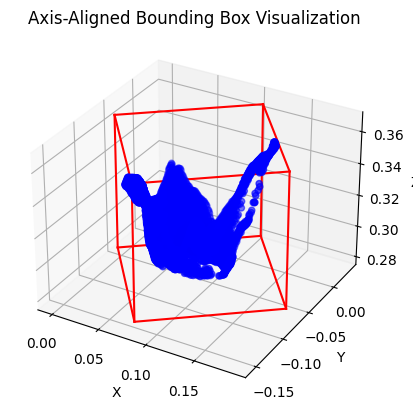

In [27]:
aabb_min = obb.get_min_bound()
aabb_max = obb.get_max_bound()

def get_obb_corners(obb):
    center = np.array(obb.center)
    R = np.array(obb.R)
    extent = np.array(obb.extent)

    # Half extents
    half_extent = extent / 2

    # Corners relative to the center
    corners_relative = np.array([
        [-half_extent[0], -half_extent[1], -half_extent[2]],
        [ half_extent[0], -half_extent[1], -half_extent[2]],
        [ half_extent[0],  half_extent[1], -half_extent[2]],
        [-half_extent[0],  half_extent[1], -half_extent[2]],
        [-half_extent[0], -half_extent[1],  half_extent[2]],
        [ half_extent[0], -half_extent[1],  half_extent[2]],
        [ half_extent[0],  half_extent[1],  half_extent[2]],
        [-half_extent[0],  half_extent[1],  half_extent[2]]
    ])

    # Apply rotation and add center to each corner
    corners = [center + R.dot(corner) for corner in corners_relative]
    return np.array(corners)

def get_aabb_corners(aabb_min, aabb_max):
    """Get the 8 corners of the AABB based on min and max points."""
    corners = [
        [aabb_min[0], aabb_min[1], aabb_min[2]],
        [aabb_max[0], aabb_min[1], aabb_min[2]],
        [aabb_max[0], aabb_max[1], aabb_min[2]],
        [aabb_min[0], aabb_max[1], aabb_min[2]],
        [aabb_min[0], aabb_min[1], aabb_max[2]],
        [aabb_max[0], aabb_min[1], aabb_max[2]],
        [aabb_max[0], aabb_max[1], aabb_max[2]],
        [aabb_min[0], aabb_max[1], aabb_max[2]]
    ]
    return np.array(corners)


# Function to plot lines between given points
def plot_lines(ax, points, connections, color='r'):
    """Plot lines between points based on the provided connections."""
    for con in connections:
        p1, p2 = points[con[0]], points[con[1]]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color)

# Define the corner connections for an AABB
connections = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom rectangle
    (4, 5), (5, 6), (6, 7), (7, 4),  # Top rectangle
    (0, 4), (1, 5), (2, 6), (3, 7)   # Side lines connecting top and bottom
]

# Get the corners of the AABB
aabb_corners = get_obb_corners(obb_2d_transformed)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the AABB by connecting its corners
plot_lines(ax, aabb_corners, connections)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o', label='Points')


# Setting labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Axis-Aligned Bounding Box Visualization')

plt.show()

In [28]:

def unit_vector(vector):
    print(vector)
    """Calculate the unit vector of the given vector."""
    # Calculate the magnitude of the vector
    magnitude = np.linalg.norm(vector)
    # Handle the case where the magnitude is zero to avoid division by zero
    if magnitude == 0:
        raise ValueError("Cannot compute the unit vector of a zero vector.")
    # Calculate the unit vector
    return vector / magnitude

def rotation_matrix_to_quaternion(r):
    """
    Convert a rotation matrix to a quaternion.
    """
    r = R.from_matrix(r)
    return r.as_quat()

def sgn(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def find_rotation_quaternion(v1, v2):
    """
    Find the rotation quaternion from set v1 to set v2.
    v1 and v2 are lists of numpy arrays representing the x, y, z axis vectors of two coordinate systems.
    """
    # Calculate the rotation matrix
    rotation = np.dot(v2, np.linalg.inv(v1))
    
    # Convert the rotation matrix to a quaternion
    quaternion = rotation_matrix_to_quaternion(rotation)
    print(rotation)
    return quaternion

def get_face_transformations(obb, corners):
    center = np.asarray(obb.center)
    print(center)
    centers = [
        (corners[5]+corners[0])/2,  # Front face center (parallel to XY plane at min Y)
        (corners[6]+corners[1])/2,  # Back face center (parallel to XY plane at max Y)
        (corners[7]+corners[2])/2,  # Left face center (parallel to YZ plane at min X)
        (corners[4]+corners[3])/2  # Right face center (parallel to YZ plane at max X)
    ]
    print(centers)
    face_vectors = np.asarray([
        [corners[1] - corners[0], corners[4] - corners[0]],  # Using bottom rectangle
        [corners[2] - corners[1], corners[5] - corners[1]],   # Using top rectangle
        [corners[3] - corners[2], corners[6] - corners[2]],   # Side faces
        [corners[0] - corners[3], corners[7] - corners[3]]
    ])
    # Unit vectors for each face 
    # Front, Right, Back, Left
    face_unit_vectors = np.asarray([
        [unit_vector(centers[0]-center),unit_vector(face_vectors[0,0]), unit_vector(face_vectors[0,1])],  
        [unit_vector(centers[1] - center), unit_vector(face_vectors[1,0]), unit_vector(face_vectors[1,1])],  
        [unit_vector(centers[2] - center), unit_vector(face_vectors[2,0]), unit_vector(face_vectors[2,1])],  
        [unit_vector(centers[3] - center), unit_vector(face_vectors[3,0]), unit_vector(face_vectors[3,1])]
    ])

    world_frame = np.array([[1,0,0],[0,1,0],[0,0,1]])
    face_quoternions = [find_rotation_quaternion(world_frame, face_unit_vectors[i]) for i in range(4)]
    return centers, face_quoternions

In [29]:
displacements, quaternions = get_face_transformations(obb_2d_transformed, get_obb_corners(obb_2d_transformed))
for i in range(4):
    print("Displacement: ", displacements[i], "Rotation: ", quaternions[i])

[ 0.0929341  -0.06128842  0.3235    ]
[array([ 0.13376235, -0.11206066,  0.3235    ]), array([ 0.14682319, -0.01795376,  0.3235    ]), array([ 0.05210584, -0.01051618,  0.3235    ]), array([ 0.039045  , -0.10462309,  0.3235    ])]
[ 0.04082825 -0.05077224  0.        ]
[0.1077782  0.08666932 0.        ]
[0.    0.    0.085]
[0.0538891  0.04333466 0.        ]
[-0.08165651  0.10154448  0.        ]
[0.    0.    0.085]
[-0.04082825  0.05077224  0.        ]
[-0.1077782  -0.08666932  0.        ]
[0.    0.    0.085]
[-0.0538891  -0.04333466  0.        ]
[ 0.08165651 -0.10154448  0.        ]
[0.    0.    0.085]
[[ 0.62666277 -0.77929056  0.        ]
 [ 0.77929056  0.62666277  0.        ]
 [ 0.          0.          1.        ]]
[[ 0.77929056  0.62666277  0.        ]
 [-0.62666277  0.77929056  0.        ]
 [ 0.          0.          1.        ]]
[[-0.62666277  0.77929056  0.        ]
 [-0.77929056 -0.62666277  0.        ]
 [ 0.          0.          1.        ]]
[[-0.77929056 -0.62666277  0.        

In [5]:
R.from_quat([0.7072, 0.0, -0.7072, 0.0]).as_euler("xyz")

/tmp/ipykernel_5809/2435492454.py:1: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  R.from_quat([0.7072, 0.0, -0.7072, 0.0]).as_euler("xyz")


array([-3.14159265,  1.57079631,  0.        ])